# Visualization

We have a *ton* of options for viz in python.
I'm going to focus on matplotlib and seaborn, because they work well for the types of analyses I usually do.
At the end, I'll mention Altair, which is new but has a really good design.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('default')

In [2]:
%matplotlib inline

To start with, we'll fetch some data from yahoo using the `pandas_datareader` package.

In [3]:
stocks = pd.read_csv("data/stocks.csv", index_col="Date", parse_dates=['Date'])
stocks.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2006-01-03,126.699997,129.440002,124.230003,128.869995,6188700,113.396301
2006-01-04,127.349998,128.910004,126.379997,127.089996,4861600,111.830030
2006-01-05,126.000000,127.320000,125.610001,127.040001,3717400,111.786038
2006-01-06,127.290001,129.250000,127.290001,128.839996,4319600,113.369904
2006-01-09,128.500000,130.619995,128.000000,130.389999,4723500,114.733795


## Matplotlib

- foundation for seaborn and pandas plotting
- full control over every detail

We won't say too much about matplotlib directly.
It's a large library with several different levels of API.
Additionally, both seaborn and pandas use matplotlib internally so you can consider these two higher-level, domain specific APIs built on top of matplotlib proper.
This works well, as you can use the higher-level library most of the time, but you still have the full power and control of matplotlib when you need it.

People familiar with matplotlib will have used the `axes.plot` method; It takes an `x`, `y` and a bunch of keyword arguments.

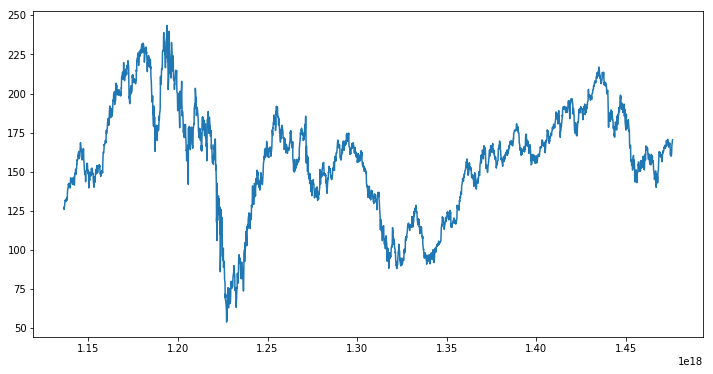

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(stocks.Open);

Notice that matplotlib is now pandas-aware.
`ax.plot` knows that when it's passed a `Series`, like `stocks.Open`, then `stocks.index` makes for a good `x` axis.

All the `axes` plot methods `.plot, .bar, .scatter`, etc. take an optional *data* argument. When passed, you can use strings as the `x` and `y`. matplotlib will use these strings as keys for `data.__getitem__`. This means `data` can be DataFrames, dictionaries, even H5Py files.

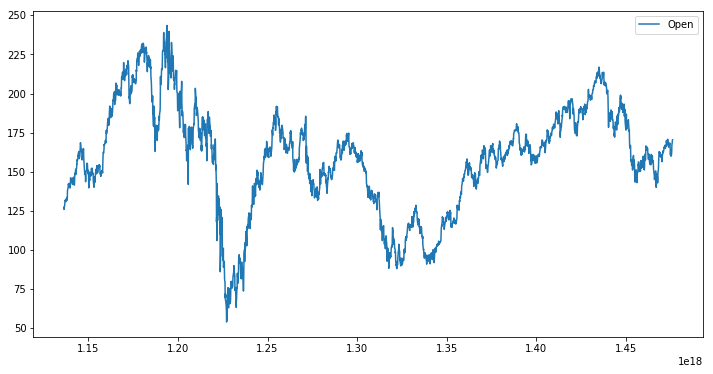

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot('Open', data=stocks)
plt.legend();

Matplotlib's strength (and weakness) is it's customizability. With enough work, you can make essentially any figure you want.

In [6]:
import warnings


with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    import statsmodels.tsa.api as smt

from pandas.tseries import converter

converter.register()

In [7]:
ϵ, t = smt.filters.hpfilter(stocks.Close, lamb=129600*30)

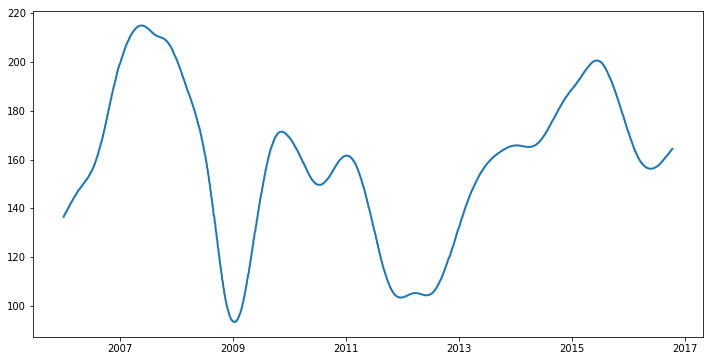

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
line, = ax.plot(t, linewidth=2, label="Trend")

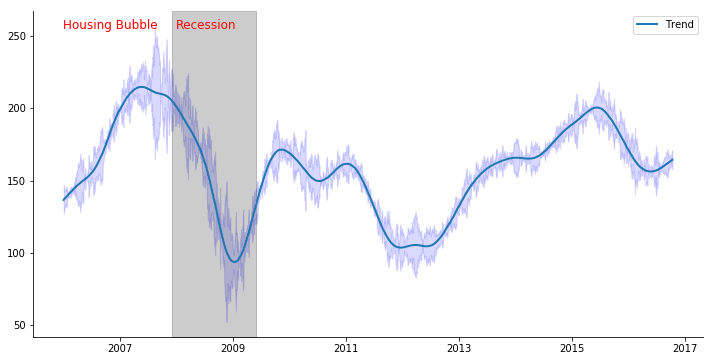

In [9]:
start = pd.Timestamp('2007-12-01')
end = pd.Timestamp('2009-06-01')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t, linewidth=2, label="Trend")

ax.fill_between(t.index, t - ϵ, t + ϵ, alpha=.15, color='b')

ylim = ax.get_ylim()
ax.fill_between([start, end], *ylim, color='k', alpha=.2)
ax.set_ylim(*ylim)

ax.annotate("Housing Bubble", (pd.Timestamp("2006-01"),  255),
            fontsize=12, color='red')
ax.annotate("Recession", (pd.Timestamp("2008-01"),  255),
            fontsize=12, color='red')

ax.legend()
sns.despine()

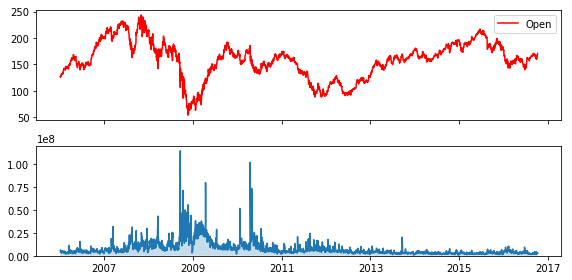

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 4), sharex=True)

ax1.plot("Open", data=stocks, color='red')
ax2.plot("Volume", data=stocks)
ax2.fill_between(stocks.index, 0, "Volume", data=stocks, alpha=.25)
ax2.set_ylim(0)
ax1.legend()

plt.tight_layout()

## Pandas Plotting

> Usually convenient

- Previously, nicer aesthetics (not since matplotlib 2.0)
- Nicer labeling (but matplotlib is better now)
- Easier (though less flexible) subplotting

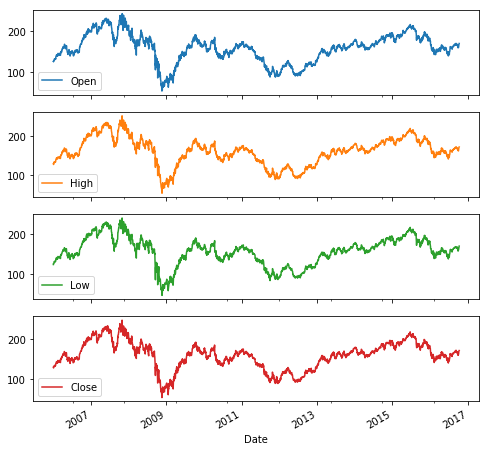

In [11]:
stocks[['Open', 'High', "Low", "Close"]].plot(subplots=True, figsize=(8, 8));

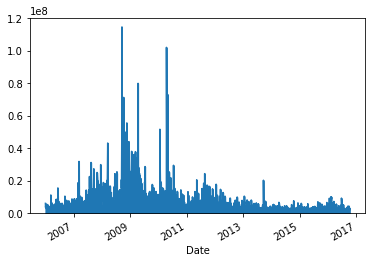

In [12]:
stocks.Volume.plot.area();

I'd recommend pandas builtin plotting for when you need a quick visualization.
For simple customizations, you can typically followup a pandas plot with an `ax.set`:

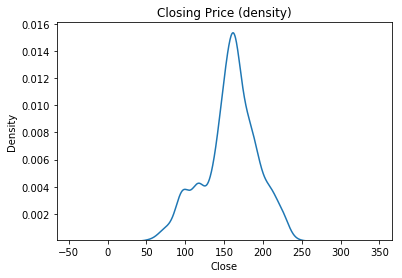

In [13]:
ax = stocks.Close.plot.density()
ax.set(xlabel="Close", title="Closing Price (density)", ylim=.0001);

For more elaborate customizations, it can make sense to just start with matplotlib.

## [Seaborn](http://seaborn.pydata.org/)

> Seaborn provides a high-level interface for drawing attractive statistical graphics.

- Statistical aggregations (`countplot`, bootstrapped standard errors, `regplot`)
- Easier distribution plotting
- Easier faceting by variable

It is *not* a replacement of matplotlib. Rather, it provides a nice API for
many common statistical methods. Some of the distinguishing features are

We'll make an update of [this notebook](https://gist.github.com/mwaskom/8224591) from Michael Waskom, the author of seaborn, which explores the titanic dataset:

## Titanic Dataset

- Survived
- Class
- Sex
- Age
- Embarked
- Man / Woman / Child
- Deck

In [ ]:
t = sns.load_dataset('titanic')
t['class'] = t['class'].cat.as_ordered()
t.head()

In [ ]:
t.info()

In [ ]:
pal = dict(man="#4682B4", woman="#CD5C5C", child="#2E8B57", male="#6495ED",
           female="#F08080")

with sns.color_palette('viridis', n_colors=3) as v:
    pal.update(**dict(zip(['First', 'Second', 'Third'], v.as_hex())))

sns.set(context='talk', style='white')

## Exploratory Analysis

1. Who were the passengers?
2. Who survived?

## Who were the passengers?

Explore them across different dimensions; We'll start with *categorical* data like sex or class.

What's the count of passengers by sex?

In [ ]:
import warnings

In [ ]:
# This has been fixed in seaborn master
warnings.filterwarnings('ignore', message="remove_na",
                        category=FutureWarning)

sns.countplot(x="sex", data=t, palette=pal);

By class?

In [ ]:
sns.countplot(x="class", data=t, palette=pal);

By "who" (man, woman, or child)?

In [ ]:
sns.countplot("who", data=t, palette=pal)
sns.despine()

Seaborn is built up of a heirarchy of convenience functions and methods.
For instance, `countplot` is essentially a specialized version of `factorplot` where `kind` is set to count.

In [ ]:
sns.factorplot(x="class", data=t, kind="count", hue="sex",
               palette=pal, size=7);

Most seaborn functions have the same API. You pass the requeired arguments (`x`, `y`, etc. depending on the plot), a `data` argument.
Include additional arguments like `hue`, `col`, etc. as needed.

Why have both `countplot` and `factorplot(..., kind='count')`? The specialized versions like `countplot` are handy when working with `Grid`s, which we'll see later on.

<div class="alert alert-success" data-title="Embarked by class">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Embarked by class</h1>
</div>

<p>Make a `factorplot` with the counts of `embarked`, with the `hue` split
by `class`.</p>

In [ ]:
# Your solution


In [ ]:
%load solutions/visualize_00.py


<div class="alert alert-success" data-title="Age by class">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Age by class</h1>
</div>
<p>
Make a pointplot of `age` by `class`. Look at the `kind` parameter to `sns.factorplot`.</p>

In [ ]:
# Your solution here


In [ ]:
%load solutions/visualize_01.py

## Distributions

Let's moving to plotting *quantitative* data.
We'll do this while introducting a new abstraction from seaborn, the `Grid` (`Grid`s work with either quantitative or qualitative data).

## Grids

You initalize a `Grid` with all the agruments needed to layout the grid that
the data will be plotted on:

- `data`: DataFrame
- `row` : variable to facet rows by
- `col` : variable to facet columns by
- `hue` : variable to split colors by

There are several kinds of `Grid`s in seaborn; we'll start with the `FacetGrid`.

In [ ]:
g = sns.FacetGrid(t, hue="sex", aspect=2.5, palette=pal)

We haven't actually done any plotting really.
Just the necessary work to layout the axes.

To actually plot something, `map` plotting functions over the `FacetGrid`. The arguments to `g.map` are passed through to the underlying plot method like `sns.kdeplot`.

In [ ]:
g = sns.FacetGrid(t, hue="sex", aspect=2.5, palette=pal)
g.map(sns.kdeplot, "age", shade=True)
g.set(xlim=(0, 80), ylim=0)
g.add_legend();

To show how the faceting works, pass `row` or `column` when setting up the `FacetGrid`:

In [ ]:
g = sns.FacetGrid(t, row="sex", hue="sex", aspect=2.5, palette=pal)
g.map(sns.kdeplot, "age", shade=True)
g.set(xlim=(0, 80), ylim=0)
g.add_legend();

In [ ]:
g = sns.FacetGrid(t, hue="who", aspect=2.5, palette=pal)
g.map(sns.kdeplot, "age", shade=True)
g.set(xlim=(0, 80), ylim=0)
g.add_legend();

In [ ]:
g = sns.FacetGrid(t, hue="class", aspect=3, palette="YlGn_r")
g.map(sns.kdeplot, "age", shade=True)
g.set(xlim=(0, 80), ylim=0)
g.add_legend();

You can get quite complicated results, without much additional work.

In [ ]:
g = (sns.FacetGrid(t, col="sex", row="class", size=2.5, aspect=2.5,
                   palette=pal, hue="sex")
     .map(sns.kdeplot, "age", shade=True)
     .map(sns.rugplot, "age")
     .set(xlim=(0, 80), ylim=0));

This is a great asset when exploring a new dataset.

In [ ]:
sns.factorplot('deck', data=t, palette='PuBu_d',
               kind="count");

Your data isn't always in perfect shape to be plotted, so you'll be mixing in data manipulations with actual plotting:

In [ ]:
sns.violinplot("class", "fare", data=t, orient="v",
               palette="YlGn")
sns.despine(left=True)

<div class="alert alert-success" data-title="Trimming">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Trimming</h1>
</div>
<p>
Create a new column in `t` called `fare_` that topcodes `fare` to be no more than `3 * t.fare.median()`. That is, anything higher than 3x the median should just be set to 3x the median.</p>

Hint: you can use `np.where` to simulate an `if x then y else z` on arrays of data.

In [ ]:
# Your solution here


In [ ]:
%load solutions/visualize_02a.py

Now make the violinplot on fares that we tried above:

In [ ]:
# Your solution here


In [ ]:
%load solutions/visualize_02b.py


Seaborn makes it easy to split by an additional variable, like `sex`.

In [ ]:
sns.violinplot("class", "fare_", data=t, orient="v",
               palette="YlGn", hue='sex', split=True)
sns.despine(left=True)
plt.ylim(0);


## Plotting Relationships

We've seen summary statistics (like countplot), univariate distributions, and basic relationships between one variable and a categorical variable.

Seaborn also provides tools for visualizng bivariate relationships between quantitative variables.

In [ ]:
ax = sns.jointplot("age", "fare_", data=t, color="g", size=8);

## Who Survived?

Let's turn to the variable of interest: who survived?

<div class="alert alert-success" data-title="Who Survived?">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Who Survived?</h1>
</div>

<p>Explore the `alive` variable</p>

What does the count of alive look like?

In [ ]:
%load solutions/visualize_03.py

What's the relationship between class and survived?

In [ ]:
%load solutions/visualize_04.py


What's the relationship between who and survived

In [ ]:
%load solutions/visualize_05.py


What's the interaction of `sex` with `class`, when predicting `survived`? Split the `hue` by `sex`.

Hint: `class` is a categorical (AKA factor), so use `factorplot`.

In [ ]:
%load solutions/visualize_06.py


How about the interaction of `'who'` with class?

In [ ]:
%load solutions/visualize_07.py


What's the relationship between `survived` and `adult_male`?

In [ ]:
%load solutions/visualize_08.py


## Regression plots

You can plot relationships with best fit lines (and bootstrapped standard errors) using `lmplot`.

In [ ]:
sns.lmplot("age", "survived", t, logistic=True, y_jitter=.05);

Since we have a binary target (`survived`), we use `logistic`. It can be more informative to bin the x variable.

In [ ]:
bins = [15, 30, 45, 60]
sns.lmplot("age", "survived", t, logistic=True,
           x_bins=bins);

<div class="alert alert-success" data-title="Survived by gender">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Survived by gender</h1>
</div>


<p>Can you split that relationship by `sex`?</p>

In [ ]:
%load solutions/visualize_09.py


How about class?

In [ ]:
%load solutions/visualize_10.py


## Seaborn Summary

- Many small functions with a consistent API (`x`, `y`, `data`, etc.)
- `Grid`s offer an abstraction for (relatively) easy faceting